## 1. Import Data and Libraries

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from copy import deepcopy
from collections import OrderedDict, defaultdict
from typing import List, Tuple

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
random.seed(42)
np.random.seed(42)

%matplotlib inline

In [2]:
def mnist_imshow(img):
    """
    Plot MNIST image
    
    Parameters
    ----------
    img: torch.Tensor
    """
    plt.imshow(img.reshape(28,28), cmap="gray")
    plt.axis('off')
    plt.show()
    
    
class PermutedMNIST(datasets.MNIST):
    
    def __init__(self, root="~/.torch/data/mnist", train=True, permute_idx=None):
        """
        Permuted MNIST Datasets
        """
        super(PermutedMNIST, self).__init__(root, train, download=True)
        assert len(permute_idx) == 28 * 28
        self.data = torch.stack([img.float().view(-1)[permute_idx] / 255
                                 for img in self.data])

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        return img, target

    
    def get_sample(self, sample_size):
        sample_idx = random.sample(range(len(self)), sample_size)
        return [(self.data[i], self.targets[i]) for i in sample_idx]

In [3]:
def get_permute_mnist(num_tasks, batch_size, val_size=None):
    """
    Get the permute MNIST dataset for each task
    
    Parameters
    ----------
    num_tasks: float
        Number of tasks
        
    batch_size: float
        Batch size
        
    val_size: float or int
        Size of validation set
        
    Returns
    -------
    train_loader: dict
        Train permute MNIST dataset for each task
    test_loader: dict
        Test permute MNIST dataset for each task
    val_loader: dict
        Validation permute MNIST dataset for each task
    """
    train_loader = dict()
    test_loader = dict()
    idx = list(range(28 * 28))
    
    if val_size is None:
        for i in range(num_tasks):
            train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=True, permute_idx=idx),
                                                          batch_size=batch_size)
            test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=False, permute_idx=idx),
                                                         batch_size=batch_size)
            random.shuffle(idx)

        return train_loader, test_loader
    else:
        val_loader = dict()

        for i in range(num_tasks):
            train_dataset = PermutedMNIST(train=True, permute_idx=idx)
            indices = list(range(len(train_dataset)))
            train_size = len(train_dataset) - val_size
            train_indices, val_indices = indices[:train_size], indices[train_size:]
            
            # Creating data samplers and loaders:
            train_sampler = SubsetRandomSampler(train_indices)
            val_sampler = SubsetRandomSampler(val_indices)
            
            train_loader[i] = torch.utils.data.DataLoader(train_dataset,
                                                          batch_size=batch_size, sampler=train_sampler)
            test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=False, permute_idx=idx),
                                                         batch_size=batch_size)
            val_loader[i] = torch.utils.data.DataLoader(train_dataset,
                                                        batch_size=batch_size, sampler=val_sampler)
            random.shuffle(idx)

        return train_loader, test_loader, val_loader

## 2. EWC

In [4]:
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

In [5]:
class EWC:
    def __init__(self, model: nn.Module):
        """
        A class that use Elastic Weight Consolidation to train model in Continual Learning
        """
        self.model = model
        self.params = {name: param for name, param in self.model.named_parameters() if param.requires_grad}
        
        
    def normal_train(self, data_loader: torch.utils.data.DataLoader, optimizer: torch.optim):
        """
        Train the model on the data_loader with 1 epoch using the optimizer without EWC
        
        Parameters
        ----------
        data_loader: torch.utils.data.DataLoader
            The data that we want to train the model on.

        optimizer: torch.optim
        
        Returns
        ------
        output: float
            Loss after training the model in 1 epoch.
        """
        
        self.model.train()
        epoch_loss = 0
        
        for img, target in data_loader:
            # Move data to GPU
            img_ = variable(img)
            target_ = variable(target)
            output = self.model(img_)
            loss = F.cross_entropy(output, target_)
        
            # Backward pass
            optimizer.zero_grad()
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        return epoch_loss / len(data_loader)
    
    
    def get_params(self):
        """
        Return the current parameters of the model
        """
        params = dict()
        for name, param in deepcopy(self.params).items():
            params[name] = variable(param.data)
            
        return params
    
    
    def test(self, data_loader: torch.utils.data.DataLoader):
        """
        Compute the accuracy and loss of the model on test data
        
        Parameters
        ----------
        data_loader: torch.utils.data.DataLoader
            The data that we want to test the model on.
        
        Returns
        ------
        output: Tuple[float, float]
            Accuracy and Loss of the model on the data.
        """
        
        self.model.eval()
        correct = 0
        loss = 0
        
        with torch.no_grad():
            for img, target in data_loader:
                # Move data to GPU
                img_ = variable(img)
                target_ = variable(target)
                output = self.model(img_)
                loss += F.cross_entropy(output, target_).data.item()
                correct += (F.softmax(output, dim=1).max(dim=1)[1] == target_).data.sum().item()
          
        return correct / len(data_loader.dataset), loss / len(data_loader.dataset)
        
    
    def compute_fisher(self, dataset: List[Tuple[torch.Tensor, torch.Tensor]]):
        """
        Compute the diagonal Fisher information matrix for each parameter
        
        Parameters
        ----------
        dataset: List[Tuple[torch.Tensor, torch.Tensor]]
            The dataset that we want to compute the Fisher Matrix on, may contain data from previous tasks.
            
        Returns
        -------
        fisher_matrix: dict
            A dictionary that map each parameter to the value on the diagonal of the FIM.
        """
        
        fisher_matrix = dict()
    
        # Make a copy of the parameters
        for name, param in deepcopy(self.params).items():
            param.data.zero_()
            fisher_matrix[name] = variable(param)
        
        self.model.eval()
        for i in range(len(dataset)):
            self.model.zero_grad()
            img = variable(dataset[i][0])
            # target = variable(dataset[i][1])
            output = self.model(img).view(1, -1)
            target = output.view(1, -1).max(dim=1)[1].view(-1)
            loss = F.nll_loss(F.log_softmax(output, dim=-1), target)
            loss.backward()
            
            for name, param in self.model.named_parameters():
                fisher_matrix[name].data += (param.grad.data ** 2) / len(dataset)
                
        fisher_matrix = {name: param for name, param in fisher_matrix.items()}
        return fisher_matrix
    
    
    def penalty(self, fisher_matrix: dict, params: dict):
        """
        Compute the Penalty - See the Paper for details
        
        Parameters
        ----------
        fisher_matrix: dict
            Fisher Matrix
        params: dict
            Old values of the parameters
            
        Returns
        -------
        loss: Penalty - See the paper for more details 
        """
        loss = 0
        for name, param in self.model.named_parameters():
            _loss = fisher_matrix[name] * ((param - params[name]) ** 2)
            loss += _loss.sum()
        
        return loss
    
    
    def ewc_train(self, data_loader: torch.utils.data.DataLoader, optimizer: torch.optim, importances: List[float] or float, fisher_matrices: List[dict], params: dict):
        """
        Train the model on the data_loader with 1 epoch using the optimizer with EWC
        
        Parameters
        ----------
        data_loader: torch.utils.data.DataLoader
            The data that we want to train the model on.

        optimizer: torch.optim
        
        importances: List[float] or float
            How important the old tasks are compared to the new one
            
        fisher_matrices: List[dict]
            A List of FIM
            
        params: dict
            Old tasks parameters
        
        Returns
        -------
        output: float
            Loss after training the model in 1 epoch.
        """
        
        self.model.train()
        epoch_loss = 0
        
        num_old_tasks = len(fisher_matrices)
        
        for img, target in data_loader:
            # Move data to GPU
            img_ = variable(img)
            target_ = variable(target)
            output = self.model(img_)
            loss = F.cross_entropy(output, target_)
            
            # Compute the penalty
            for i in range(num_old_tasks):
                if isinstance(importances, float) or isinstance(importances, int):
                    loss += importances * self.penalty(fisher_matrices[i], params)
                else:
                    loss += importances[i] * self.penalty(fisher_matrices[i], params)
        
            # Backward pass
            optimizer.zero_grad()
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        return epoch_loss / len(data_loader)
    
    
    def l2_train(self, data_loader: torch.utils.data.DataLoader, optimizer: torch.optim, importances: float, params: dict):
        """
        Train the model on the data_loader with 1 epoch using the optimizer with l2-regularization
        
        Parameters
        ----------
        data_loader: torch.utils.data.DataLoader
            The data that we want to train the model on.

        optimizer: torch.optim
        
        importances: float
            How important the old tasks are compared to the new one

        params: dict
            Old tasks parameters
        
        Returns
        ------
        output: float
            Loss after training the model in 1 epoch.
        """
        
        self.model.train()
        epoch_loss = 0
        
        for img, target in data_loader:
            # Move data to GPU
            img_ = variable(img)
            target_ = variable(target)
            output = self.model(img_)
            loss = F.cross_entropy(output, target_)
            
            for name, param in self.model.named_parameters():
                _loss = importances * ((param - params[name]) ** 2)
                loss += _loss.sum()
        
            # Backward pass
            optimizer.zero_grad()
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        return epoch_loss / len(data_loader)

## 3. MNIST Experiments

### 3.1. Three Tasks with SGD, L2-regularization and EWC

In [6]:
# Hyperparameters setting
epochs = 20
batch_size = 128
num_tasks = 3
learning_rate = 1e-3
use_cuda = True
hidden_size = 400
num_hidden_layers = 2

# EWC
importance = 100
sample_size = 10000

In [7]:
train_loader, test_loader = get_permute_mnist(num_tasks=num_tasks, batch_size=batch_size)

#### 3.1.1. SGD

In [8]:
# Create Models
model= nn.Sequential(OrderedDict([
        ('hidden_linear1', nn.Linear(28 * 28, hidden_size)),
        ('hidden_activation1', nn.ReLU()),
        ('hidden_linear2', nn.Linear(hidden_size, hidden_size)),
        ('hidden_activation2', nn.ReLU()),
        ('output_linear', nn.Linear(hidden_size, 10))
    ]))

if torch.cuda.is_available() and use_cuda:
    model.cuda()
    
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
model_ewc = EWC(model)

# Accuracy on all tasks
test_acc_sgd = defaultdict(list)


for task in range(num_tasks):
    for _ in range(epochs):
        # Train on current task
        epoch_loss = model_ewc.normal_train(data_loader=train_loader[task], optimizer=optimizer)
        
        # Test on previous tasks and current task
        for sub_task in range(task + 1):
            acc, loss = model_ewc.test(data_loader=test_loader[sub_task])
            test_acc_sgd[sub_task].append(acc)

#### 3.1.2. l2-Regularization

In [9]:
# Create Models
model= nn.Sequential(OrderedDict([
        ('hidden_linear1', nn.Linear(28 * 28, hidden_size)),
        ('hidden_activation1', nn.ReLU()),
        ('hidden_linear2', nn.Linear(hidden_size, hidden_size)),
        ('hidden_activation2', nn.ReLU()),
        ('output_linear', nn.Linear(hidden_size, 10))
    ]))

if torch.cuda.is_available() and use_cuda:
    model.cuda()
    
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
model_ewc = EWC(model)

# Accuracy on all tasks
test_acc_l2 = defaultdict(list)
old_task_params = None

# Train Models
for task in range(num_tasks):
    for _ in range(epochs):
        # Train on current task
        if task == 0:
            epoch_loss = model_ewc.normal_train(data_loader=train_loader[task], optimizer=optimizer)
        else:
            epoch_loss = model_ewc.l2_train(data_loader=train_loader[task], optimizer=optimizer, importances=importance, params=old_task_params)
        
        # Test on previous tasks and current task
        for sub_task in range(task + 1):
            acc, loss = model_ewc.test(data_loader=test_loader[sub_task])
            test_acc_l2[sub_task].append(acc)
            
    old_task_params = model_ewc.get_params()

#### 3,1.3. EWC

In [10]:
# Create Models
model= nn.Sequential(OrderedDict([
        ('hidden_linear1', nn.Linear(28 * 28, hidden_size)),
        ('hidden_activation1', nn.ReLU()),
        ('hidden_linear2', nn.Linear(hidden_size, hidden_size)),
        ('hidden_activation2', nn.ReLU()),
        ('output_linear', nn.Linear(hidden_size, 10))
    ]))

if torch.cuda.is_available() and use_cuda:
    model.cuda()
    
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
model_ewc = EWC(model)

# Accuracy on all tasks
test_acc_ewc = defaultdict(list)
old_task_params = None
fisher_matrices = []

# Train Models
for task in range(num_tasks):        
    for _ in range(epochs):
        # Train on current task
        if task == 0:
            epoch_loss = model_ewc.normal_train(data_loader=train_loader[task], optimizer=optimizer)
        else:
            epoch_loss = model_ewc.ewc_train(data_loader=train_loader[task], optimizer=optimizer, importances=importance, fisher_matrices=fisher_matrices, params=old_task_params)
        
        # Test on previous tasks and current task
        for sub_task in range(task + 1):
            acc, loss = model_ewc.test(data_loader=test_loader[sub_task])
            test_acc_ewc[sub_task].append(acc)
            
    fisher_matrices.append(model_ewc.compute_fisher(train_loader[task].dataset.get_sample(sample_size)))
    old_task_params = model_ewc.get_params()

#### 3.1.4. Results

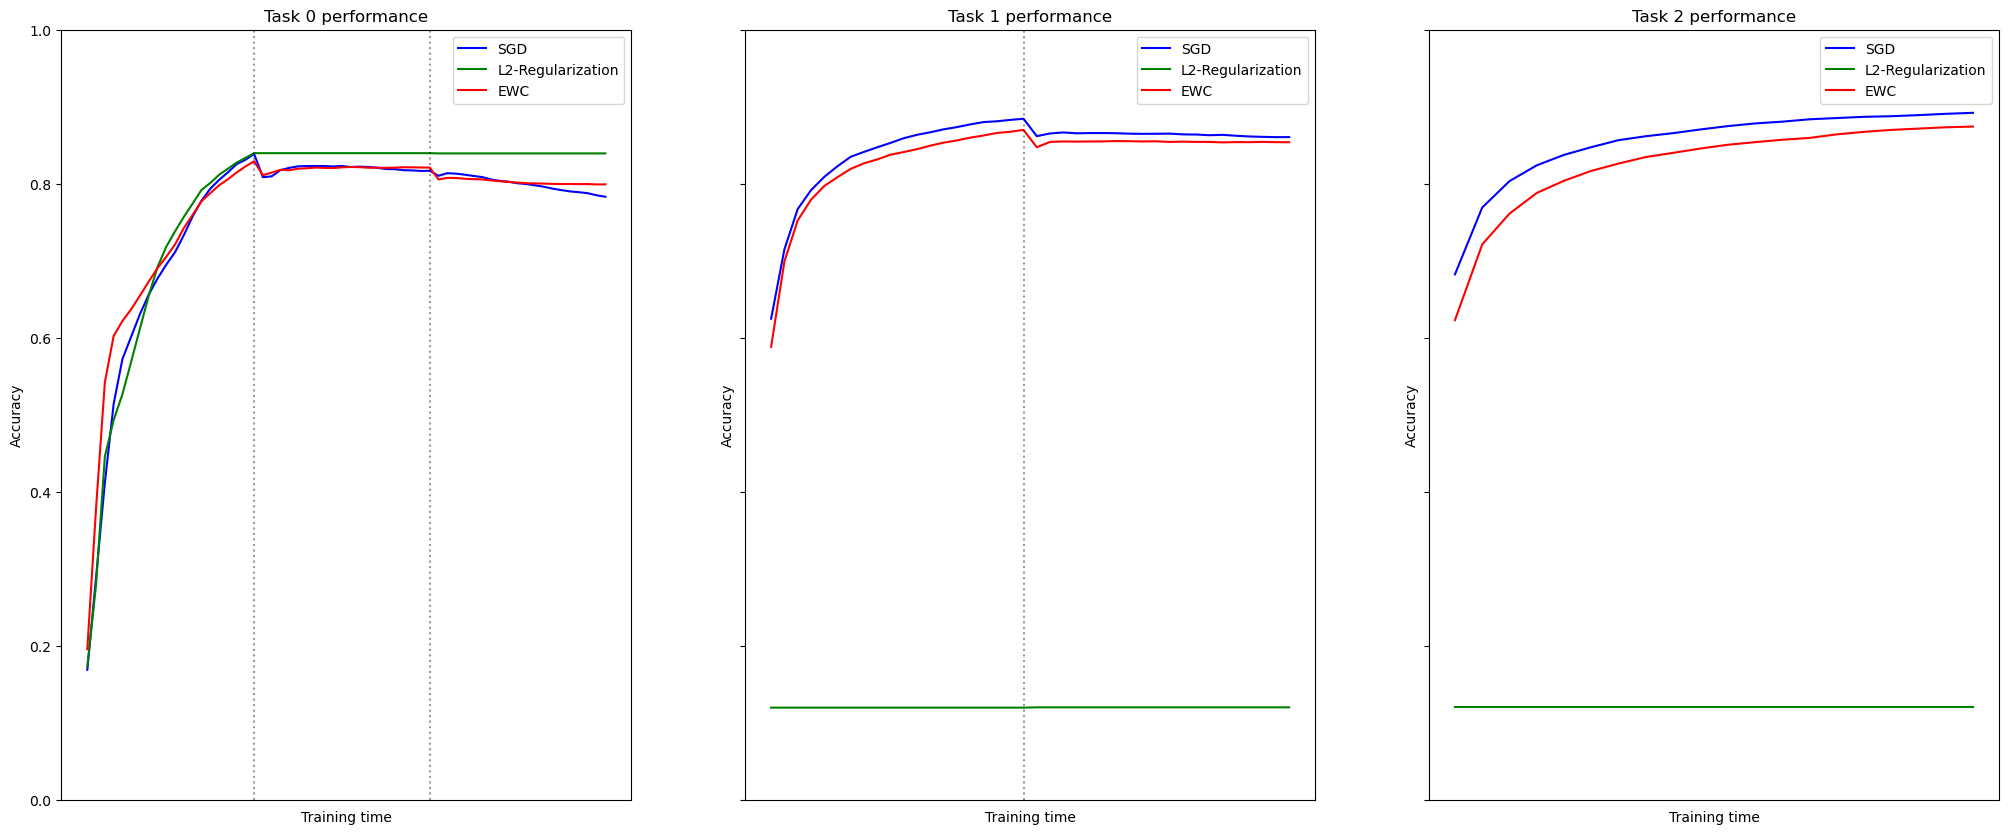

In [11]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(25, 10))

for task in range(num_tasks):
    ax[task].plot(list(range(len(test_acc_sgd[task]))), test_acc_sgd[task], label='SGD', c='blue')
    ax[task].plot(list(range(len(test_acc_l2[task]))), test_acc_l2[task], label='L2-Regularization', c='green')
    ax[task].plot(list(range(len(test_acc_ewc[task]))), test_acc_ewc[task], label='EWC', c='red')
    ax[task].set(
        title=f'Task {task} performance',
        xlabel='Training time',
        ylabel='Accuracy',
        xticks=[],
        ylim=(0, 1)
    )

    if task <= 1:
        ax[task].vlines(x=epochs - 1, ymin=0, ymax=1, linestyles='dotted', colors='black', alpha=0.4)
    if task == 0:
        ax[task].vlines(x=2*epochs - 1, ymin=0, ymax=1, linestyles='dotted', colors='black', alpha=0.4)
    ax[task].legend()

__Discussion__
- We can see that performance of EWC on task 0 is still very good after we train on 3 tasks.
- Performance of EWC on task 1 and task 2 is comparable to SGD
- Although performance of L2-regularization on task 0 is good, but on the other tasks are not (maybe because of the `importance` parameters)
- On task 1, EWC performance is lower than SGD because EWC must also adjust its weight to task 0

__Note__ 
- `importance` can be a list that indicates how important each task is.
- We can change `importance` and `epochs` to adjust l2-regularization and EWC performance

### 3.2. Ten tasks with SGD + Dropout and EWC

In [13]:
# Hyperparameters setting
epochs = 100
batch_size = 128
num_tasks = 10
learning_rate = 1e-3
use_cuda = True
hidden_size = 1500
num_hidden_layers = 2

# Early stopping
val_size = 10000
patience = 5 

# EWC
importance = 1
sample_size = 10000

In [14]:
train_loader, test_loader, val_loader = get_permute_mnist(num_tasks=num_tasks, batch_size=batch_size, val_size=val_size)

#### 3.2.1. SGD + Dropout

In [15]:
# Create Model with Dropout
model= nn.Sequential(OrderedDict([
        ('dropout1', nn.Dropout(p=0.2)),
        ('hidden_linear1', nn.Linear(28 * 28, hidden_size)),
        ('hidden_activation1', nn.ReLU()),
        ('dropout2', nn.Dropout(p=0.5)),
        ('hidden_linear2', nn.Linear(hidden_size, hidden_size)),
        ('hidden_activation2', nn.ReLU()),
        ('dropout3', nn.Dropout(p=0.5)),
        ('output_linear', nn.Linear(hidden_size, 10))
    ]))

if torch.cuda.is_available() and use_cuda:
    model.cuda()
    
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
model_ewc = EWC(model)

# Accuracy on all tasks
test_acc_sgd = []


for task in range(num_tasks):
    patience_counter = 0
    val_last_acc = 0
    best_weight = None
    
     # Train on current task
    for epoch in range(epochs):
        epoch_loss = model_ewc.normal_train(data_loader=train_loader[task], optimizer=optimizer)
        
        # Test on validation set of all previous tasks
        val_acc = 0
        for sub_task in range(task + 1):
            acc, loss = model_ewc.test(data_loader=val_loader[sub_task])
            val_acc += acc
        val_acc = val_acc / (task + 1)  # average
        
        # Check Early Stopping
        if val_acc >= val_last_acc:
            # Update acc and weight
            val_last_acc = val_acc
            best_weight = model_ewc.model.state_dict()
            
            # Reset patience counter
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter == patience:
                print(f'Task {task} stop training at epoch {epoch}')
                model_ewc.model.load_state_dict(best_weight)
                break
                
            if epoch == epochs - 1:  # Last epoch
                model_ewc.model.load_state_dict(best_weight)
        
    # Test on previous tasks
    old_tasks_acc = 0
    for sub_task in range(task + 1):
        acc, loss = model_ewc.test(data_loader=test_loader[sub_task])
        old_tasks_acc += acc
    old_tasks_acc = old_tasks_acc / (task + 1)
    
    test_acc_sgd.append(old_tasks_acc)
    print(f'Finish training on task {task}')

Finish training on task 0
Finish training on task 1
Task 2 stop training at epoch 39
Finish training on task 2
Task 3 stop training at epoch 27
Finish training on task 3
Task 4 stop training at epoch 24
Finish training on task 4
Task 5 stop training at epoch 23
Finish training on task 5
Task 6 stop training at epoch 16
Finish training on task 6
Task 7 stop training at epoch 12
Finish training on task 7
Task 8 stop training at epoch 13
Finish training on task 8
Task 9 stop training at epoch 12
Finish training on task 9


#### 3.2.2. EWC

In [16]:
# Create Model with no Dropout
model= nn.Sequential(OrderedDict([
        ('hidden_linear1', nn.Linear(28 * 28, hidden_size)),
        ('hidden_activation1', nn.ReLU()),
        ('hidden_linear2', nn.Linear(hidden_size, hidden_size)),
        ('hidden_activation2', nn.ReLU()),
        ('output_linear', nn.Linear(hidden_size, 10))
    ]))

if torch.cuda.is_available() and use_cuda:
    model.cuda()
    
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
model_ewc = EWC(model)

# Accuracy on all tasks
test_acc_ewc = []
old_task_params = None
fisher_matrices = []

for task in range(num_tasks):
    patience_counter = 0
    val_last_acc = 0
    best_weight = None
    
     # Train on current task
    for epoch in range(epochs):
        if task == 0:
            epoch_loss = model_ewc.normal_train(data_loader=train_loader[task], optimizer=optimizer)
        else:
            epoch_loss = model_ewc.ewc_train(data_loader=train_loader[task], optimizer=optimizer, importances=importance, fisher_matrices=fisher_matrices, params=old_task_params)
        
        # Test on validation set of all previous tasks
        val_acc = 0
        for sub_task in range(task + 1):
            acc, loss = model_ewc.test(data_loader=val_loader[sub_task])
            val_acc += acc
        val_acc = val_acc / (task + 1)  # average
        
        # Check Early Stopping
        if val_acc >= val_last_acc:
            # Update acc and weight
            val_last_acc = val_acc
            best_weight = model_ewc.model.state_dict()
            
            # Reset patience counter
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter == patience:
                print(f'Task {task} stop training at epoch {epoch}')
                model_ewc.model.load_state_dict(best_weight)
                break
                
            if epoch == epochs - 1:  # Last epoch
                model_ewc.model.load_state_dict(best_weight)
        
    # Test on previous tasks
    old_tasks_acc = 0
    for sub_task in range(task + 1):
        acc, loss = model_ewc.test(data_loader=test_loader[sub_task])
        old_tasks_acc += acc
    old_tasks_acc = old_tasks_acc / (task + 1)  
    
    test_acc_ewc.append(old_tasks_acc)
    print(f'Finish training on task {task}')
    
    old_task_params = model_ewc.get_params()
    fisher_matrices.append(model_ewc.compute_fisher(train_loader[task].dataset.get_sample(sample_size)))

Finish training on task 0
Task 1 stop training at epoch 77
Finish training on task 1
Task 2 stop training at epoch 51
Finish training on task 2
Task 3 stop training at epoch 26
Finish training on task 3
Task 4 stop training at epoch 29
Finish training on task 4
Task 5 stop training at epoch 22
Finish training on task 5
Task 6 stop training at epoch 13
Finish training on task 6
Task 7 stop training at epoch 19
Finish training on task 7
Task 8 stop training at epoch 7
Finish training on task 8
Task 9 stop training at epoch 21
Finish training on task 9


#### 3.2.3. Results

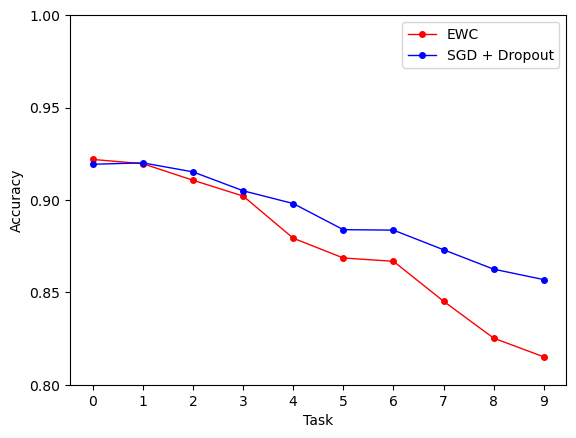

In [24]:
plt.plot(test_acc_ewc, '-o', label='EWC', c='red', lw=1, markersize=4)
plt.plot(test_acc_sgd, '-o', label='SGD + Dropout', c='blue', lw=1, markersize=4)
plt.ylabel('Accuracy')
plt.xlabel('Task')
plt.legend()
plt.ylim(0.8, 1)
plt.xticks(list(range(10)))
plt.yticks([0.80, 0.85, 0.90, 0.95, 1.00])
plt.show()

__Discussion__
- Again `importance` plays an important role. Adjust it to suit your needs. I set it to 1 only for example. I haven't tuned on it yet.
- We can dynamically change `importance`
- Maybe I had some bugs on my implementations :D Please let me know if you find out